In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [2]:
# Step 1: Load the dataset from the CSV file
data = pd.read_csv(r'C:\Users\Rabab\Downloads\iris.csv')

In [3]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
# Step 2: Split the dataset into features (X) and target (y)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [6]:
# Check the distribution of target classes (heart disease or not)
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
print(class_counts)  # Print the number of samples in each class 

{'Iris-setosa': 50, 'Iris-versicolor': 50, 'Iris-virginica': 50}


In [7]:
# Step 3: Normalize the features
# Standardize the features to have a mean of 0 and variance of 1 using StandardScaler.
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# Step 4: Convert target labels to numerical values using LabelEncoder (e.g., 0, 1, 2)
# This converts categorical labels to integers.
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [9]:
# Step 5: Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Step 6: Convert the numpy arrays to PyTorch tensors for neural network training
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [47]:
# Step 7: Define the neural network architecture with additional complexity and dropout regularization
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        # Define the architecture: 4 input features -> 128 neurons -> 64 neurons -> 64 neurons -> 3 output neurons
        self.fc1 = nn.Linear(4, 128)  # First fully connected layer (input: 4, output: 128)
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer (input: 128, output: 64)
        self.fc3 = nn.Linear(64, 64)  # Third fully connected layer (input: 64, output: 64)
        self.fc4 = nn.Linear(64, 3)  # Output layer (input: 64, output: 3 classes)

    # Define the forward pass through the network
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = torch.relu(self.fc3(x))  # ReLU activation for the third layer
        x = self.fc4(x)  # No activation for the output layer, raw logits
        x = torch.softmax(x, dim=1)  # Softmax for converting logits to probabilities
        return x

In [48]:
# Instantiate the model
model = IrisNet()

# Step 8: Define the loss function (CrossEntropyLoss) and optimizer (Adam) with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

# Step 9: Train the model using mini-batches
epochs = 100  # Train for 100 epochs
batch_size = 16  # Use mini-batch size of 16

# Create DataLoader to load the training data in batches
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [49]:
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss for this epoch

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Forward pass: compute predictions
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
        
        total_loss += loss.item()  # Accumulate the total loss
    
    # Print the average loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')


Epoch [10/100], Loss: 1.0804
Epoch [20/100], Loss: 1.0491
Epoch [30/100], Loss: 0.9930
Epoch [40/100], Loss: 0.9038
Epoch [50/100], Loss: 0.8299
Epoch [60/100], Loss: 0.7934
Epoch [70/100], Loss: 0.7653
Epoch [80/100], Loss: 0.7325
Epoch [90/100], Loss: 0.7084
Epoch [100/100], Loss: 0.6902


In [50]:
# Step 10: Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest score (prediction)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)  # Calculate accuracy
    print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 96.67%


[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]


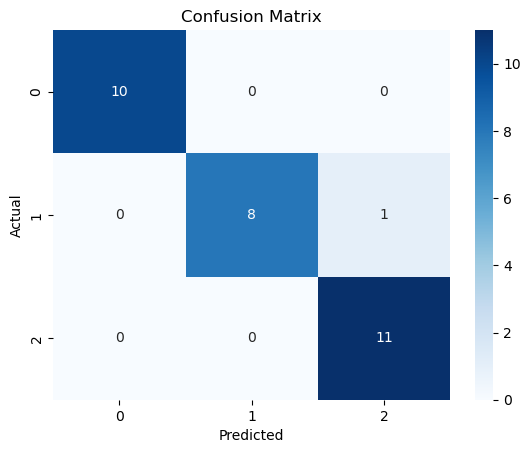

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.89      0.94         9
 Iris-virginica       0.92      1.00      0.96        11

       accuracy                           0.97        30
      macro avg       0.97      0.96      0.97        30
   weighted avg       0.97      0.97      0.97        30



In [51]:
# Step 11: Plot the confusion matrix to visualize the classification results
cm = confusion_matrix(y_test, predicted)
print(cm)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Step 12: Print the classification report for precision, recall, F1-score
print(classification_report(y_test, predicted, target_names=encoder.classes_))


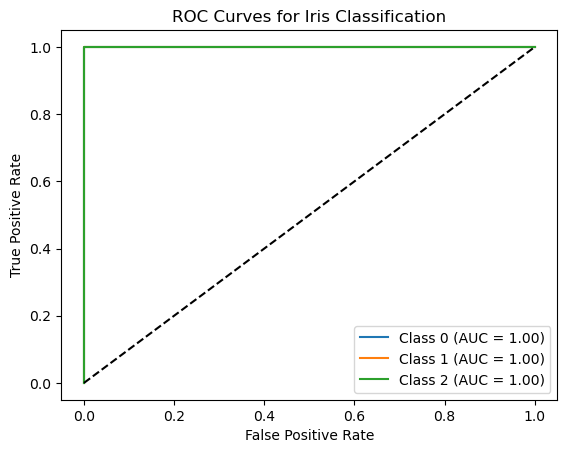

In [52]:
# Step 13: Plot ROC-AUC Curves for each class (One-vs-Rest)
# Binarize the output labels for One-vs-Rest ROC-AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Apply softmax to the outputs to get probabilities for each class
y_score = torch.softmax(outputs, dim=1).numpy()

fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and ROC area for each class
for i in range(3):  # Loop through each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_score[:, i])

# Plot ROC Curves for each class
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Iris Classification')
plt.legend()
plt.show()

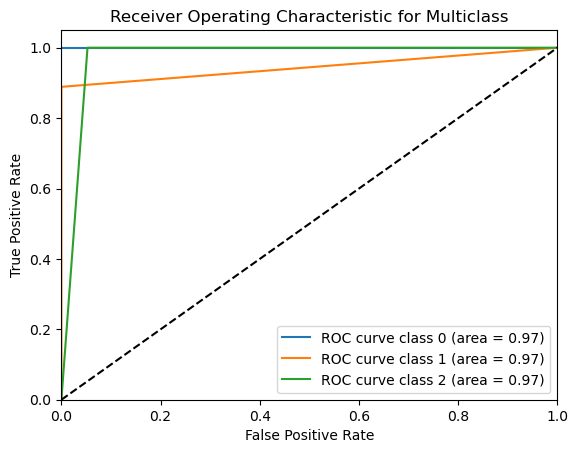

In [53]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming y_test and predicted are available
# Convert y_test and predicted to a binary format for multiclass
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust based on your classes
predicted_bin = label_binarize(predicted, classes=[0, 1, 2])  # Adjust based on your classes

# Calculate ROC AUC for each class
roc_auc = roc_auc_score(y_test_bin, predicted_bin, average='macro')

# Calculate ROC curve
fpr = {}
tpr = {}
thresholds = {}
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_bin[:, i], predicted_bin[:, i])

# Plotting
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve class {0} (area = {1:0.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()
